In [3]:
import pandas as pd
import numpy as np
from qgrid import show_grid
from datetime import datetime,timedelta, time
import matplotlib.pyplot as plt
import tensorflow as tf
import copy
from scipy.interpolate import make_interp_spline
import matplotlib.dates as dates
from collections import Counter
plt.style.use('ggplot')

import reddit_thread_pull as rtp
import eda
import preprocess
import model

### TRAIN MODEL

In [4]:
file_name_1 = "my_training_data/train_liv_man.csv"
file_name_2 = "my_training_data/train_liv_ars.csv"

In [5]:
def read_training_data(file_name):
    """pd in file must have columns called text and label"""
    train_read = pd.read_csv(file_name, index_col = 0)
    train_read = train_read.sample(frac = 1).reset_index(drop = True)
    print(train_read)#shuffles data
    smallest_n = min(Counter(train_read.label).values())
    zero_ind = np.where(train_read.label == 0)[0][range(smallest_n)]
    one_ind = np.where(train_read.label == 1)[0][range(smallest_n)]
    #two_ind = np.where(train_read.label == 2)[0][range(smallest_n)]
    even_classes_ind = np.concatenate((zero_ind,one_ind)) #,two_ind
    train_read = train_read.iloc[even_classes_ind,:]
    train_read = train_read.sample(frac = 1).reset_index(drop = True)
    n = len(train_read)
    train_size = round(n*.80)
    val_size = n-(train_size+1)
    train, test = train_read.iloc[range(train_size),:], train_read.iloc[range(train_size, train_size + val_size),:]
    X_train, y_train, X_test, y_test = np.asarray(train.text), np.asarray(train.label),np.asarray(test.text),np.asarray(test.label)
    data = ((X_train,y_train),(X_test,y_test))
    return data

In [6]:
data_1 = read_training_data(file_name_1)

                                                   text      sent  label
0     how did he get away with it if he got a yellow...  0.062287    0.0
1     How many more times can Tyler mention that we ...  0.411292    0.0
2     Zinchenko is their week link. Need Trent to ke...  0.565248    0.0
3     How many yellows is Thiago away from a suspens...  0.112913    0.0
4             Lovely strike Bobby, more of those please  0.865288    1.0
...                                                 ...       ...    ...
1060                 Trent looking like a passenger lol  0.544532    2.0
1061  fuck off penalty to them shits fuck cunts fuck...  0.038579    2.0
1062                                      Thiago, mate.  0.693937    0.0
1063  Bobby is such a confidence player. He had the ...  0.365893    1.0
1064  Let's stop our own counter attack just to pass...  0.540823    0.0

[1065 rows x 3 columns]


In [7]:
data_2 = read_training_data(file_name_2)

               date_time                                               text  \
0    2019-10-30 21:13:33            Brewster not getting any calls his way.   
1    2019-10-30 20:02:02  Elliot is really good, genuinely excited about...   
2    2019-10-30 20:58:35                                 I'm enjoying this.   
3    2019-10-30 20:45:49                                     HE CAN HIT ONE   
4    2019-10-30 20:59:10                I ai t even mad, this is a fun game   
..                   ...                                                ...   
597  2019-10-30 20:45:58  Get in Ox. Honestly let’s fucking win this the...   
598  2019-10-30 20:46:02                             Fuck that was worth it   
599  2019-10-30 20:46:49                                        Fuck yes ox   
600  2019-10-30 20:12:15                                Always Rated Elliot   
601  2019-10-30 20:43:12  Even milners making mistakes wtf is happening ...   

     label  
0        0  
1        1  
2        1  

In [8]:
model_text, val_acc, val_loss = model.train_ngram_model(data_2, epochs = 100, layers = 2,dropout_rate = 0.1, units = 128)

1
Train on 419 samples, validate on 104 samples
Epoch 1/100
419/419 - 1s - loss: 0.6905 - acc: 0.5346 - val_loss: 0.6879 - val_acc: 0.5481
Epoch 2/100
419/419 - 0s - loss: 0.6792 - acc: 0.6181 - val_loss: 0.6806 - val_acc: 0.5962
Epoch 3/100
419/419 - 0s - loss: 0.6658 - acc: 0.6921 - val_loss: 0.6733 - val_acc: 0.6442
Epoch 4/100
419/419 - 0s - loss: 0.6533 - acc: 0.7613 - val_loss: 0.6654 - val_acc: 0.6827
Epoch 5/100
419/419 - 0s - loss: 0.6425 - acc: 0.7804 - val_loss: 0.6570 - val_acc: 0.7019
Epoch 6/100
419/419 - 0s - loss: 0.6276 - acc: 0.8043 - val_loss: 0.6473 - val_acc: 0.7500
Epoch 7/100
419/419 - 0s - loss: 0.6110 - acc: 0.8568 - val_loss: 0.6368 - val_acc: 0.7596
Epoch 8/100
419/419 - 0s - loss: 0.5946 - acc: 0.8640 - val_loss: 0.6256 - val_acc: 0.7981
Epoch 9/100
419/419 - 0s - loss: 0.5787 - acc: 0.9021 - val_loss: 0.6131 - val_acc: 0.8077
Epoch 10/100
419/419 - 0s - loss: 0.5603 - acc: 0.9021 - val_loss: 0.5996 - val_acc: 0.8269
Epoch 11/100
419/419 - 0s - loss: 0.5369 

### READ DATA I WANT SENTIMENT FROM


In [9]:
thread_id = 'l41upg' #manu liv
#thread_id = "leop9e" #liv city
match = rtp.reddit_thread(thread_id)
match_df = match.access_comments()

Version 7.0.0 of praw is outdated. Version 7.2.0 was released Wednesday February 24, 2021.


### EDA

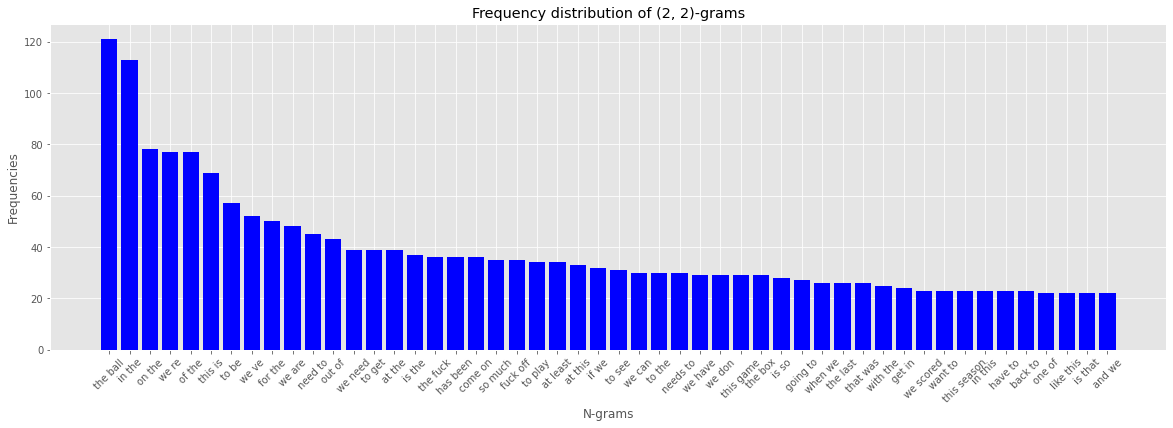

In [10]:
eda.plot_frequency_distribution_of_ngrams(match_df.text, ngram_range = (2,2), num_ngrams=50)

### Preprocesss

In [11]:
_, X_new = preprocess.ngram_vectorize(data_2[0][0],data_2[0][1],np.array(match_df.text))

### Model

In [12]:
predictions = model_text.predict(X_new)
match_df['predicted_sentiment'] = predictions

In [13]:
conditions = [
    (match_df.predicted_sentiment > 0.7),
    (match_df.predicted_sentiment < 0.2),
    (match_df.predicted_sentiment > 0.2) & (match_df.predicted_sentiment < 0.7)
]

values = [1,-1,0]

In [14]:
match_df['predicted_label'] = np.select(conditions,values)

In [15]:
def sentiment_diff_intervals(df, game_times, minute_delta):
    """
    df: df with columns called 'pos' and 'neg' and 'date_time'
   within game_times: 
    game_date: datetime object with date but no time of game date
    game_start: datetime object with time but no date of game start
    game_end: datetime object with time but no date of game end
    minute_delta: int specifying the time interval in minutes to collect sentiment over
    """
    start_full = datetime.combine(game_times[0],game_times[1].time())
    end_full = datetime.combine(game_times[0],game_times[4].time())
    time_seq = []
    time_seq.append(start_full)
    sent = []
    time = start_full
    it = 0
    df.index = df.date_time
    df.index.name = 'my_ind'
    while time < end_full:
        it = it + 1
        time = time + timedelta(minutes = minute_delta)
        time_seq.append(time)
        window_df = df.between_time(time_seq[it-1].time(),time_seq[it].time())
        sent.append(np.mean(window_df['predicted_label']))
    sent = np.array(sent)
    return sent,np.array(time_seq)[1:]

def get_smooth_sentiments(time_seq, sents):
    date_num = dates.date2num(time_seq)
    date_num_smooth = np.linspace(date_num.min(), date_num.max(), 100)
    spl = make_interp_spline(date_num, sents, k=3)
    sent_np_smooth = spl(date_num_smooth)
    date_smooth = dates.num2date(date_num_smooth)
    return np.array(date_smooth),np.array(sent_np_smooth)    

def plot_sentiments(times, sents, label, game_times, goals):
    liv_goals_first = goals[0][0]
    liv_goals_second = goals[0][1]
    op_goals_first = goals[1][0]
    op_goals_second = goals[1][1]

    plt.figure(figsize = [20,8])
    plt.plot(times,sents, label = label)
    plt.legend()
    plt.annotate("GAME START", (game_start,0))

        
    for goal in liv_goals_first:
         plt.annotate("L", (game_times[1]+timedelta(minutes = goal),0.0))

    for goal in op_goals_first:
         plt.annotate("O", (game_times[1]+timedelta(minutes = goal),0.0))
    
    plt.annotate("1",(game_times[2], 0.0)) #HALFTIME BEGINS
    plt.annotate("2",(game_times[3], 0.0)) #HALFTIME ENDS
    
    for goal in liv_goals_second:
        plt.annotate("L", (game_times[3]+timedelta(minutes = goal-45),0.0))   
    for goal in op_goals_second:
        plt.annotate("O", (game_times[3]+timedelta(minutes = goal-45),0.0))   

    plt.annotate("GAME END" , (game_times[4],0))
    
    plt.show()


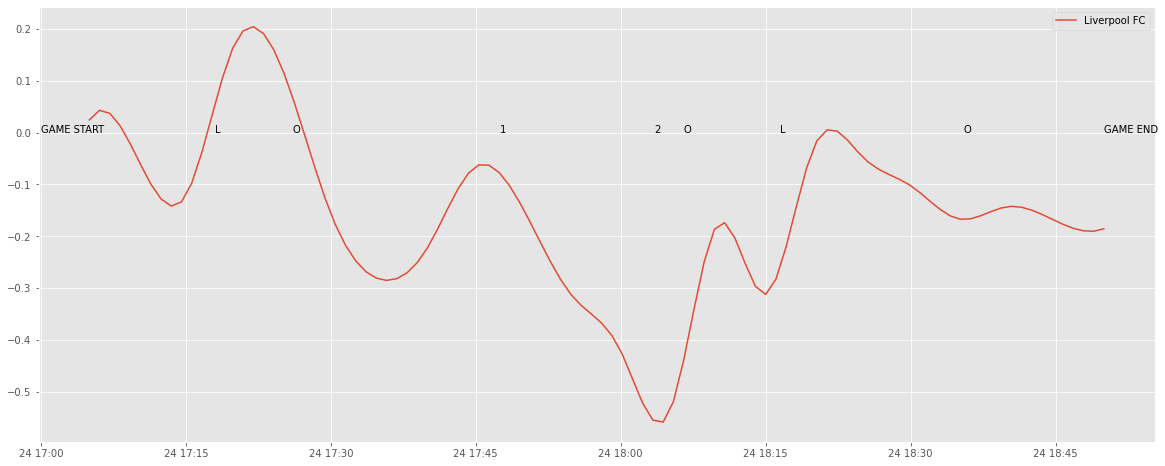

In [16]:
game_date = datetime(2021,1,24)
game_start = datetime(2021,1,24,17,0,0)
half_start = datetime(2021,1,24, 17, 47, 30)
half_end = datetime(2021,1,24, 18, 3, 30)
game_end = datetime(2021,1,24,18,50,0)
goals = (([18],[58]),([26],[48,77]))
game_times = (game_date,game_start,half_start,half_end,game_end)
sents, time_seq = sentiment_diff_intervals(match_df,game_times,5)
time_seq, sents=  get_smooth_sentiments(time_seq,sents)
plot_sentiments(time_seq, sents, 'Liverpool FC', game_times, goals)